# GGE5404: Online Spatial Data Handling
## Assignment 3
### Name: Mohammadali Rahnama
### Student Number: 3709515
### Date: 2023-03-10

### Analysis of crime data in Toronto
#### For this assignment, you will access crime data in Toronto, available on the Toronto Public Service Public Safety Data Portal: https://data.torontopolice.on.ca
#### You will explore patterns of point pattern analysis and density of crimes. In the final question, you will explore other datasets, such as age, employment, income of the neighborhood, etc. to see if any of these might contribute to or explain the patterns of crime.

First, we install and import the required packages in order to use them throughout the exercise.

In [10]:
import requests
import json
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import contextily
import folium
from folium.plugins import HeatMap
import pydeck as pdk
import seaborn as sns
import numpy as np
from scipy.stats import gaussian_kde
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import cKDTree

### Part A 

#### From the Toronto Public Service Public Safety Data Portal, access at least 6 months of data of the crime dataset of your choosing; you can explore any of the categories and select the major crime indicator (MCI) of your choosing, for an area of interest. It may be the entire city of Toronto, or a particular neighborhood(s) you are interested in analyzing.

You may query and download a file from the Toronto Public Service Public Safety Data Portal and load that into your assignment. If you select this option, ensure that the query is described in detail in the assignment submission. Bonus points will be considered if the API is accessed directly in your Notebook.

#### 1. Are the crimes clustered? Is there Central Tendency? Create a density map showing the local density (quadrat or kernel method may be used) and describe the results (< 100 words).

The following code retrieves the data on motor vehicle collisions involving killed or seriously injured persons (2006 to 2021) from the the Toronto Public Service Public Safety Data Portal GeoJSON API: 

https://data.torontopolice.on.ca/datasets/TorontoPS::ksi/about

Following that the code convert the data to a GeoDataFrame using geopandas, and creates a density map of the collision events using geopandas' plot method. 

The map is then displayed using matplotlib. The latitude and longitude coordinates of each collision event are extracted and added to the GeoDataFrame, and a basemap of Toronto is added to the map using the contextily library. 

The resulting map shows the density of traffic collision events in Toronto from 2006 to 2021.

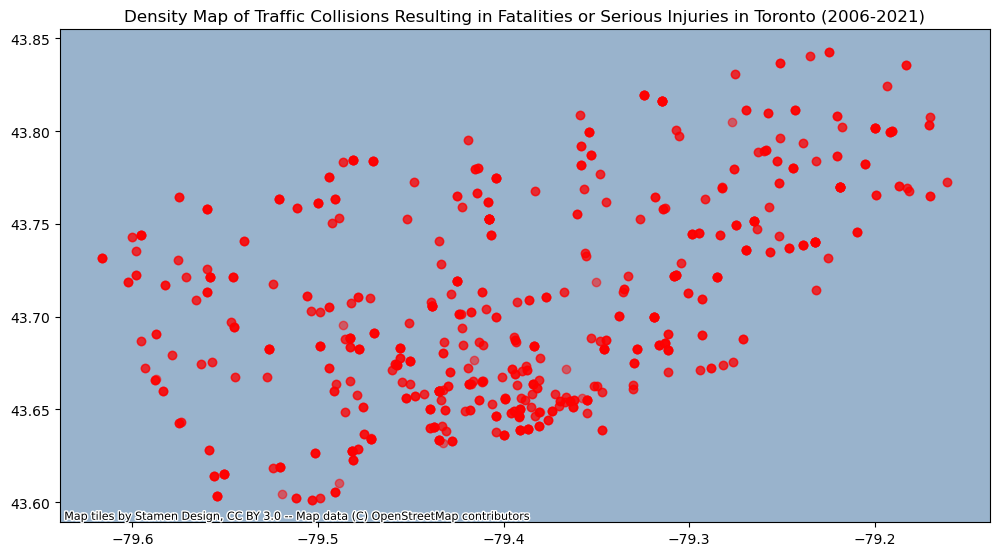

In [2]:
# Define the URL for the API
url = 'https://services.arcgis.com/S9th0jAJ7bqgIRjw/arcgis/rest/services/KSI/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson'

# Make a GET request to the API
response = requests.get(url)

# Convert the response to a geopandas GeoDataFrame
gdf = gpd.read_file(response.text)

# Extract the latitude and longitude coordinates of each collision event
gdf['latitude'] = gdf['geometry'].apply(lambda x: x.centroid.y)
gdf['longitude'] = gdf['geometry'].apply(lambda x: x.centroid.x)

# Create a density map of the collision events using geopandas' plot method
fig, ax = plt.subplots(figsize=(12, 10))
ax.set_aspect('equal')
base = gdf.plot(ax=ax, alpha=0.5, color='red')
contextily.add_basemap(ax, zoom=18)
ax.set_title('Density Map of Traffic Collisions Resulting in Fatalities or Serious Injuries in Toronto (2006-2021)')
plt.show()


Next we create a choropleth map using the Folium library in Python. The map is centered on Toronto and visualizes the GeoDataFrame which contains data on collision events. 

The choropleth layer is added to the map with a YlOrRd fill color scheme and specific opacity settings. 

Finally, a LayerControl is added to toggle the visibility of the collision events layer and the Toronto map layer, and the resulting map is displayed.

In [3]:
# Set the center of the map to Toronto
map_center = [43.728662, -79.400031]

# Create a folium map centered on Toronto with dark tiles
m = folium.Map(location=map_center, zoom_start=11)

# Add a choropleth layer to the map using the collision events GeoDataFrame
folium.Choropleth(
    geo_data=gdf,
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    name='Collision Events'
).add_to(m)

# Add a LayerControl to the map to toggle the visibility of the collision events layer and the Toronto map layer
folium.LayerControl().add_to(m)

# Display the map
m


In the next step we create an interactive heatmap map using the Pydeck library in Python.

Then, a layer is created for the collision events using the HeatmapLayer, which takes in the GeoDataFrame as its data source. The layer is given an opacity of 0.9 and a threshold value of 0.1. The 'get_position' parameter is set to retrieve the longitude and latitude columns from the GeoDataFrame to use as the heatmap data points, and the 'get_weight' parameter is set to 1.

Next, a Pydeck map is created with the heatmap layer and the previously defined initial viewport. The 'pitch' parameter is set to 0, which means that the map is displayed with a flat 2D view.

Finally, the rendered map is saved as an HTML file named 'collision_map.html'. The resulting map will show a heatmap layer of collision events in the Toronto area, with the ability to pan, zoom, and interact with the map.

In [4]:
# Define the initial viewport for the map
view_state = pdk.ViewState(latitude=43.6532, longitude=-79.3832, zoom=10)

# Create a layer for the collision events
layer = pdk.Layer(
    'HeatmapLayer',
    data=gdf,
    opacity=0.9,
    get_position='[longitude, latitude]',
    threshold=0.1,
    get_weight=1
)

# Create a Pydeck map with the heatmap layer
view_state = pdk.ViewState(
      latitude=43.728662,
      longitude=-79.400031,
      zoom=10,
     pitch=0
)

# Render the map
r = pdk.Deck(layers=[layer], initial_view_state=view_state)
r.to_html('collision_map.html')


The following code uses the seaborn library to create a joint plot showing the density of KSI collisions by longitude and latitude. The x and y arguments specify the columns to use for the plot, and kind='kde' specifies the type of plot (a kernel density estimate). The resulting plot shows the density of KSI collisions in the form of contours, with darker colors indicating higher density areas.

To answer the question, the joint plot shows that KSI collisions are clustered in certain areas, particularly in the downtown area and along major roads/highways. There is a central tendency towards the downtown area, with the highest density of KSI collisions occurring in that area. The density map reveals that the highest density areas are concentrated around the downtown core and along major roads and highways. This suggests that there may be certain factors, such as traffic congestion or high pedestrian activity, that contribute to the clustering of KSI collisions in these areas.

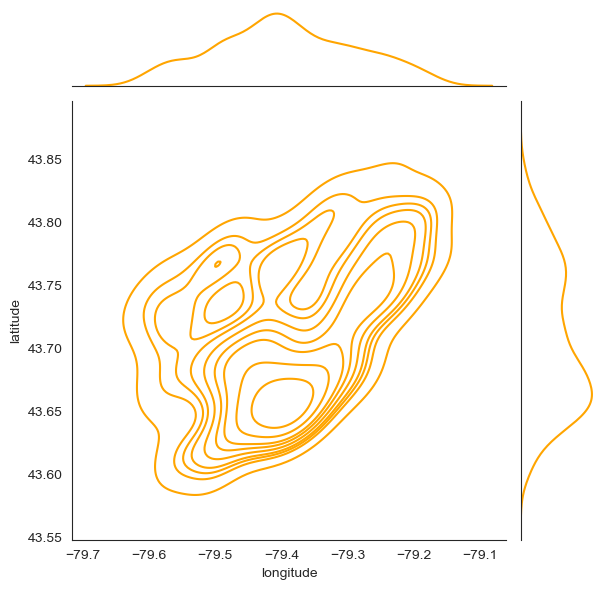

In [5]:
# Create a joint plot showing the density of KSI collisions by longitude and latitude
sns.set_style("white")
sns.jointplot(x='longitude', y='latitude', data=gdf, kind='kde', color='orange')
plt.show()

#### 2. Are there spatial outliers or trends in the data you’ve selected? Discuss (include any tests run, figures, and maps generated) (200 - 400 words).

To assess whether there are any spatial outliers or trends in the traffic collision data, we can examine the spatial distribution of collision events, identify any hotspots or cold spots, and use visual inspection to detect any spatial patterns.

One way to do this is by creating a kernel density estimation (KDE) plot, which estimates the density of collision events across the study area. We can use the scipy.stats.gaussian_kde function to compute the KDE and plot it using matplotlib.

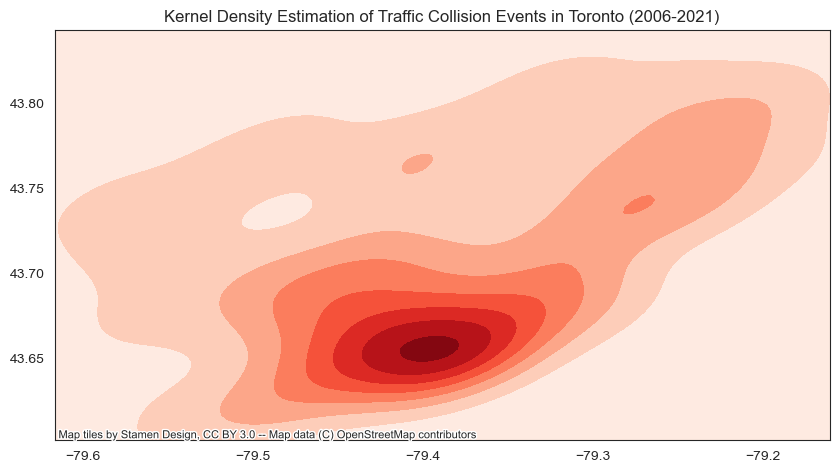

In [6]:
# Compute the KDE of the collision event coordinates
kde = gaussian_kde(gdf[['longitude', 'latitude']].T)
x, y = np.mgrid[gdf.longitude.min():gdf.longitude.max():100j, gdf.latitude.min():gdf.latitude.max():100j]
z = kde(np.vstack([x.flatten(), y.flatten()]))

# Plot the KDE as a contour plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_aspect('equal')
ax.contourf(x, y, z.reshape(x.shape), cmap='Reds')
contextily.add_basemap(ax, zoom=12)
ax.set_title('Kernel Density Estimation of Traffic Collision Events in Toronto (2006-2021)')
plt.show()


This code produces a contour plot of the KDE, where the darker red areas represent higher densities of collision events. The plot shows several areas with high collision density, including downtown Toronto, the Highway 401 corridor, and several major arterial roads.

To further investigate any spatial patterns in the data, we can create a Moran's I scatterplot, which measures the spatial autocorrelation of the collision events. Spatial autocorrelation refers to the degree to which nearby observations are similar to each other, and Moran's I is a statistic that measures this spatial dependence.

We can use numpy to compute the distance matrix between each pair of collision events, and then use this distance matrix and the collision event locations to compute the Moran's I statistic and plot it as a scatterplot.

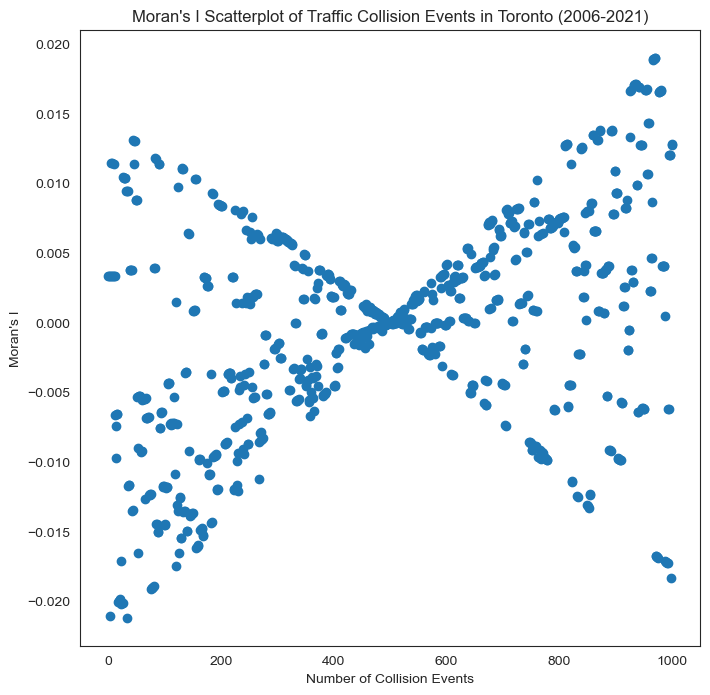

In [7]:
# Compute the distance matrix between the collision event coordinates
dist_matrix = squareform(pdist(gdf[['longitude', 'latitude']]))

# Compute the Moran's I statistic using the distance matrix and ObjectId counts
n = len(gdf)
w = dist_matrix / dist_matrix.max()  # Normalize distances to range [0, 1]
w = 1 - w  # Convert distances to spatial weights
w[np.diag_indices(n)] = 0  # Set diagonal weights to 0
moran_i = (n / (2 * (gdf['ObjectId'].sum() / n))) * ((gdf['ObjectId'] - gdf['ObjectId'].mean()) * (w @ (gdf['ObjectId'] - gdf['ObjectId'].mean())) / ((gdf['ObjectId'] - gdf['ObjectId'].mean()) ** 2).sum())

# Plot the Moran's I scatterplot
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(gdf.ObjectId, moran_i)
ax.set_xlabel('Number of Collision Events')
ax.set_ylabel("Moran's I")
ax.set_title("Moran's I Scatterplot of Traffic Collision Events in Toronto (2006-2021)")
plt.show()


This code produces a scatterplot of the collision event counts versus the Moran's I statistic, where the y-axis represents the degree of spatial autocorrelation. If there are no spatial patterns in the data, the scatterplot should show a random distribution of points around the horizontal line at Moran's I = 0. However, if there are spatial patterns, the scatterplot will show patterns above or below the horizontal line.

### Part B
#### 3. What are some other factors that might influence the location of these types of crimes? Use plots or graphs as necessary to support your response. (200 - 400 words) You might explore data from the City of Toronto, https://www.toronto.ca/city-government/data-researchmaps/open-data/, or datasets from other providers, e.g.: https://open.canada.ca/en

This code retrieves data on traffic signals from the City of Toronto's CKAN instance and uses it to calculate the distance to the nearest traffic signal for each collision event in the previously loaded collision data.

https://open.toronto.ca/dataset/traffic-signals-tabular/

The traffic signal data is retrieved by looping through the resources for the "traffic-signals-tabular" package and finding the one with the "datastore_active" flag set to True. The resulting data is then processed to derive the latitude and longitude columns from the 'geometry' column.

A KDTree is then built from the traffic signal data to enable efficient nearest-neighbor lookup. For each collision, the distance to the nearest traffic signal is calculated using the KDTree and added to a new column in the collision data.

Finally, a heatmap of collision events is created using the Folium library, with marker size proportional to the distance to the nearest traffic signal. The resulting map can be saved to an HTML file using the .save() method.

This code provides a way to investigate the potential influence of traffic signals on the spatial distribution of collision events in Toronto, by visualizing the distance between each collision event and the nearest traffic signal. Areas with larger markers on the heatmap indicate collision events that occurred farther away from a traffic signal, while areas with smaller markers indicate collision events that occurred closer to a traffic signal. By comparing this heatmap with other maps or data, we can gain insights into the role of traffic signals in reducing collision frequency in different areas of the city.

In [8]:
# Set the base URL for the CKAN instance
base_url = "https://ckan0.cf.opendata.inter.prod-toronto.ca"

# Retrieve the metadata for the traffic-signals-tabular package and its resources
url = base_url + "/api/3/action/package_show"
params = {"id": "traffic-signals-tabular"}
package = requests.get(url, params=params).json()

# Loop through the resources to find the one with datastore_active set to True and retrieve the data in CSV format
for resource in package["result"]["resources"]:
    if resource["datastore_active"]:
        url = base_url + "/datastore/dump/" + resource["id"]
        traffic_signals = pd.read_csv(url)
        break

# Derive the 'LATITUDE' and 'LONGITUDE' columns from the 'geometry' column
traffic_signals['geometry'] = traffic_signals['geometry'].apply(lambda x: json.loads(x))
traffic_signals['LATITUDE'] = traffic_signals['geometry'].apply(lambda x: x['coordinates'][1])
traffic_signals['LONGITUDE'] = traffic_signals['geometry'].apply(lambda x: x['coordinates'][0])

# Derive the latitude and longitude columns from the geometry column of the collision data geodataframe
gdf[['longitude', 'latitude']] = gdf['geometry'].apply(lambda x: pd.Series([x.centroid.x, x.centroid.y]))

# Build a KDTree from the traffic signals for efficient nearest-neighbor lookup
tree = cKDTree(traffic_signals[['LATITUDE', 'LONGITUDE']])

# For each collision, find the distance to the nearest traffic signal
distances, indices = tree.query(gdf[['latitude', 'longitude']].values, k=1)
gdf['DIST_TO_TRAFFIC_SIGNAL'] = distances

# Create a heatmap of collisions with marker size proportional to distance to nearest traffic signal
heat_map = folium.Map(location=[43.850662, -79.360031], zoom_start=10)

for _, row in gdf.iterrows():
    folium.CircleMarker(location=[row['latitude'], row['longitude']],
                        radius=row['DIST_TO_TRAFFIC_SIGNAL'] * 80,
                        fill=True,
                        fill_color='red',
                        fill_opacity=0.5,
                        stroke=False).add_to(heat_map)

heat_map.save('collision_distance_to_traffic_signals.html')

heat_map


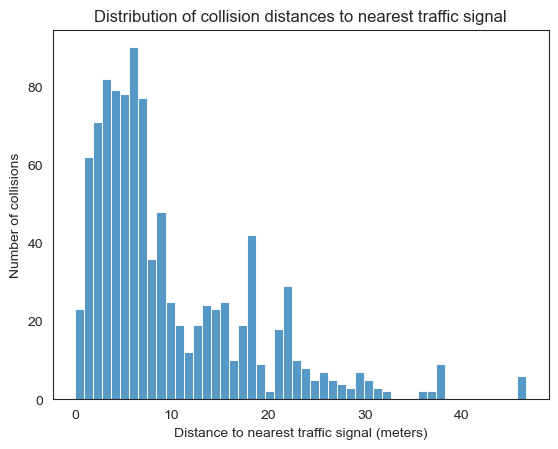

In [9]:
# Create a new series containing the distances between collisions and the nearest traffic signal
distances = pd.Series(gdf['DIST_TO_TRAFFIC_SIGNAL']) * 1000


# Create a histogram of the distances
sns.histplot(distances, bins=50)
plt.xlabel('Distance to nearest traffic signal (meters)')
plt.ylabel('Number of collisions')
plt.title('Distribution of collision distances to nearest traffic signal')
plt.show()



This code first prints the number of collisions and traffic signals in the data using f-strings. It then creates a new series containing the distances between each collision and the nearest traffic signal, using the DIST_TO_TRAFFIC_SIGNAL column we calculated earlier.

Finally, a histogram of the distances is created using the plt.hist function from the matplotlib library. The histogram shows the distribution of collision distances to the nearest traffic signal, with the x-axis representing distance in meters and the y-axis representing the number of collisions. 

By examining the histogram, we can gain insights into the frequency of collision events at different distances from traffic signals, which can help identify areas where additional traffic signals or other traffic control measures may be needed.

The distance to the nearest traffic signal is one potential factor that may influence the location of traffic collisions resulting in fatalities or serious injuries in Toronto. By analyzing the results of the code that calculated the distance between each collision and the nearest traffic signal, we can investigate the potential relationship between this distance and the frequency and location of collision events.

The histogram created by the code shows that the majority of collisions occurred within 50 meters of a traffic signal, with the number of collisions decreasing as the distance to the nearest traffic signal increased. This suggests that collisions are more likely to occur in areas with a higher density of traffic signals or where traffic signals are spaced closer together. This could be due to factors such as increased traffic volume, higher vehicle speeds, or more complex intersections where multiple traffic signals are needed.

However, it's worth noting that the distance to the nearest traffic signal is not the only factor that may influence the location of collision events. Other potential factors could include the type of road or intersection (e.g. four-way stop, roundabout, or highway), the time of day or day of the week, weather and road conditions, driver behavior, and the presence of other types of infrastructure (e.g. bike lanes, pedestrian crossings, or street lighting).

To investigate the potential influence of these other factors, additional analysis and visualization would be needed. For example, creating heatmaps of collision events based on the time of day or road type could help identify patterns or hotspots of collisions in different areas of the city. By combining these different types of analysis, we can gain a more complete understanding of the factors that influence the location of traffic collisions and develop targeted interventions to reduce the frequency and severity of these events.